Primeiro treinamento com scikit-learn

In [77]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [7]:
from sklearn.datasets import load_iris

In [8]:
iris = load_iris()

In [9]:
X = iris.data[:, [2, 3]] # petal length, petal width
y = iris.target # classe de iris

Separando em dados de treino e teste

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
xtrain , xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [12]:
np.bincount(y)

array([50, 50, 50])

In [13]:
np.bincount(ytrain)

array([35, 35, 35])

Padronizando caracteristicas

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
sc = StandardScaler()
sc.fit(xtrain)
xtrain_std = sc.transform(xtrain)
xtest_std = sc.transform(xtest)

In [16]:
from sklearn.linear_model import Perceptron

In [17]:
ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn.fit(xtrain_std, ytrain)

,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,40
,tol,0.001
,shuffle,True
,verbose,0
,eta0,0.1
,n_jobs,None
,random_state,1


In [18]:
y_pred = ppn.predict(xtest_std)

In [19]:
print(' Classes diferentes ', (ytest != y_pred).sum())

 Classes diferentes  1


In [21]:
1/ytest.shape[0] - 100

-99.97777777777777

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_pred)

0.9777777777777777

In [24]:
ppn.score(xtest_std, ytest)

0.9777777777777777

## Regressão logistica

In [69]:
class LogisticRegressionGD:
    '''
    parametros
    ----------
    eta : float
        taxa de aprendizado (default: 0.01)
    
    max_iter : int
        número máximo de iterações (default: 1000)
    
    random_state : int
        semente para geração de números aleatórios (default: None)
    
    atributos 
    ---------
    weight_ : array
    bias_   : array
    '''

    def __init__(self, eta=0.01, max_iter=50, random_state=1):
        self.eta = eta 
        self.max_iter = max_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
        torch.manual_seed(self.random_state)

        self.weight_ = torch.normal(mean=0.0, std=0.01, dtype=torch.float32, size=X.shape[1:]).reshape(-1, 1)
        self.bias_   = torch.tensor([0.0], dtype=torch.float32)
        self.losses  = []
        for i in range(self.max_iter):
            saida = self.activation(self.function_(X))
            erros = (y - saida)

            self.weight_ += self.eta * 2.0 * X.T@erros / X.shape[0]
            self.bias_    += self.eta * 2.0 * torch.mean(erros)

            loss = (
                -y.T @ torch.log(saida) 
                -((1 - y).T@torch.log(1 - saida)))/ X.shape[0]

            self.losses.append(loss)
    def function_(self, X):
        return X@self.weight_ + self.bias_
    
    def activation(self, z):
        return torch.sigmoid(z)
    
    def predict(self, X):
        return torch.where(
            self.activation(self.function_(X)) >= 0.5, 1, 0
        )

In [70]:
log = LogisticRegressionGD()

In [71]:
log.fit(xtrain_std, ytrain)

In [74]:
pred = log.predict(torch.tensor(xtest_std, dtype=torch.float32))

In [75]:
from sklearn.metrics import accuracy_score, classification_report

In [76]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.50      1.00      0.67        15
           2       0.00      0.00      0.00        15

    accuracy                           0.67        45
   macro avg       0.50      0.67      0.56        45
weighted avg       0.50      0.67      0.56        45



c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning-with-pytorch-and-scikit-learn\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning-with-pytorch-and-scikit-learn\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mateu\Documents\Norton\Projetos GIT\machine-learning-with-pytorch-and-scikit-learn\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and

### Overfitting e Underfitting

**Overfitting** ocorre quando um modelo de aprendizado de máquina se ajusta muito bem aos dados de treinamento, capturando até mesmo o ruído e as variações aleatórias presentes nesses dados. Como resultado, o modelo tem um desempenho muito bom nos dados de treinamento, mas falha em generalizar para novos dados não vistos, resultando em um desempenho ruim nos dados de teste.

**Underfitting** acontece quando um modelo é muito simples para capturar a estrutura subjacente nos dados. Isso pode ocorrer quando o modelo não tem parâmetros suficientes ou quando ele não foi treinado por tempo suficiente. Como consequência, o modelo tem um desempenho ruim tanto nos dados de treinamento quanto nos dados de teste, pois não consegue capturar as tendências dos dados adequadamente.

Se o modelo está sofrendo de overfitting podemos dizer que ele está sofrendo de uma alta variancias

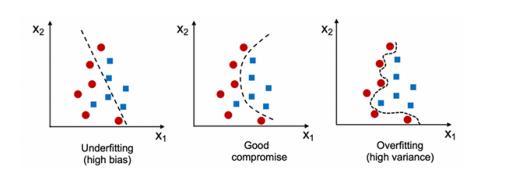

In [78]:
plt.imshow(plt.imread('img/image.png'))
plt.axis('off')  # Remove os eixos para uma visualização mais limp
plt.show()

Primerio caminho para encontrar uma boa variancias nos pesos é sintonizar a complexidade do modelo via regularização. **A regularização é um metodo muito usado para problemas de colenariedade(alta correlção entre caracteristicas)**, filtrando outros ruidos nos dados. e eventualmente prevenindo overfitting

### L2 - Reguralização

$$\lambda\frac{1}{2}||\mathbf{w}||_2^2 = \lambda\frac{1}{2}\sum_{i=1}^{m} w_i^2$$

quando mais alto o alpha mais proximo de zero ele se aproxima

In [95]:
from sklearn.linear_model import Ridge

In [100]:
for i in torch.linspace(0.1, 100, 100):
    log = Ridge(alpha=i.item(), max_iter=1000)
    log.fit(xtrain_std, ytrain)
    print(i, log.coef_)

tensor(0.1000) [0.36901675 0.42318193]
tensor(1.1091) [0.37261678 0.41572517]
tensor(2.1182) [0.37436109 0.41016151]
tensor(3.1273) [0.37506451 0.40567558]
tensor(4.1364) [0.3751291  0.40186477]
tensor(5.1455) [0.37477609 0.39850734]
tensor(6.1545) [0.37413719 0.39547107]
tensor(7.1636) [0.37329572 0.39267214]
tensor(8.1727) [0.37230687 0.39005486]
tensor(9.1818) [0.37120868 0.38758073]
tensor(10.1909) [0.37002815 0.38522225]
tensor(11.2000) [0.36878498 0.38295927]
tensor(12.2091) [0.36749388 0.38077663]
tensor(13.2182) [0.36616599 0.37866273]
tensor(14.2273) [0.36480995 0.3766085 ]
tensor(15.2364) [0.36343251 0.37460676]
tensor(16.2455) [0.36203902 0.37265172]
tensor(17.2545) [0.36063379 0.37073868]
tensor(18.2636) [0.35922029 0.36886374]
tensor(19.2727) [0.35780136 0.36702368]
tensor(20.2818) [0.35637933 0.36521576]
tensor(21.2909) [0.35495613 0.36343766]
tensor(22.3000) [0.35353337 0.36168741]
tensor(23.3091) [0.35211238 0.35996329]
tensor(24.3182) [0.3506943 0.3582638]
tensor(25.32